Human Activity Recognition with Smartphones

In [1]:
import numpy as np
import pylab as pl
import pandas as pd
import matplotlib.pyplot as plt 
import seaborn as sns
from sklearn.utils import shuffle
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix,classification_report
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.utils import resample
import time
from scipy.spatial.distance import cdist
from fastdtw import fastdtw

Input train and testing dataset

In [2]:
train = shuffle(pd.read_csv("train.csv"))
test = shuffle(pd.read_csv("test.csv"))

In [3]:
train.head()

,tBodyAcc-mean()-X,tBodyAcc-mean()-Y,tBodyAcc-mean()-Z,tBodyAcc-std()-X,tBodyAcc-std()-Y,tBodyAcc-std()-Z,tBodyAcc-mad()-X,tBodyAcc-mad()-Y,tBodyAcc-mad()-Z,tBodyAcc-max()-X,...,fBodyBodyGyroJerkMag-kurtosis(),"angle(tBodyAccMean,gravity)","angle(tBodyAccJerkMean),gravityMean)","angle(tBodyGyroMean,gravityMean)","angle(tBodyGyroJerkMean,gravityMean)","angle(X,gravityMean)","angle(Y,gravityMean)","angle(Z,gravityMean)",subject,Activity
5751,0.277351,-0.017135,-0.106814,-0.995988,-0.994745,-0.996607,-0.996367,-0.994237,-0.996889,-0.939992,...,-0.556075,-0.404091,-0.247955,-0.678512,-0.576824,0.656711,-0.558804,-0.442983,26,LAYING
1120,0.084683,0.063916,-0.066697,0.387375,-0.008854,-0.539185,0.303451,-0.106082,-0.520739,0.660661,...,-0.419385,0.605662,0.623681,-0.936030,-0.424068,-0.781147,0.249341,0.022066,6,WALKING_DOWNSTAIRS
4803,0.227920,-0.033946,-0.094711,-0.367742,-0.060711,0.190148,-0.403146,-0.217358,0.189628,-0.122904,...,-0.383312,0.464825,-0.503228,-0.684917,-0.591868,-0.738905,0.211950,0.162907,23,WALKING
4524,0.138417,-0.024460,-0.150348,0.370627,0.225344,-0.293605,0.366288,0.192435,-0.298804,0.465563,...,-0.720364,0.742786,-0.459860,0.967798,-0.762551,-0.777683,0.215793,-0.084583,22,WALKING_DOWNSTAIRS
5229,0.297819,-0.044428,-0.121008,-0.386935,-0.209733,-0.443651,-0.409051,-0.234213,-0.457049,-0.189089,...,-0.823830,-0.144710,0.649667,0.897821,-0.714276,-0.666985,0.145179,-0.217427,25,WALKING_DOWNSTAIRS


Check for missing values in the dataset

In [4]:
print("Any missing sample in training set:",train.isnull().values.any())
print("Any missing sample in test set:",test.isnull().values.any(), "\n")

Any missing sample in training set: False
Any missing sample in test set: False 



Frequency Distribution of the Outome

In [5]:
#Frequency distribution of classes"
train_outcome = pd.crosstab(index=train["Activity"],  # Make a crosstab
                              columns="count")      # Name the count column

train_outcome

col_0,count
Activity,
LAYING,1407
SITTING,1286
STANDING,1374
WALKING,1226
WALKING_DOWNSTAIRS,986
WALKING_UPSTAIRS,1073


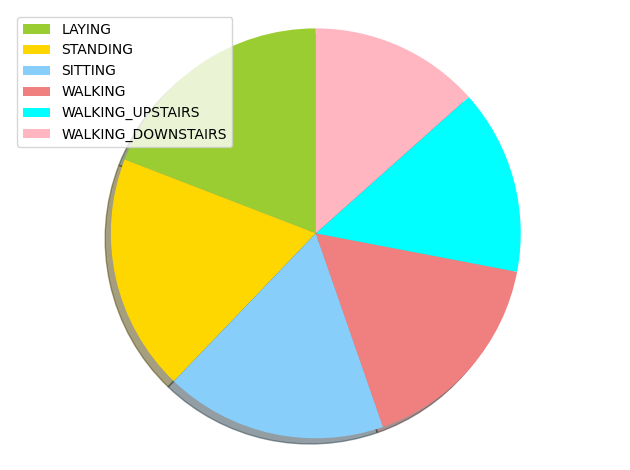

In [6]:
# Visualizing Outcome Distribution 
temp = train["Activity"].value_counts()
df = pd.DataFrame({'labels': temp.index,
                   'values': temp.values
                  })

#df.plot(kind='pie',labels='labels',values='values', title='Activity Ditribution',subplots= "True")

labels = df['labels']
sizes = df['values']
colors = ['yellowgreen', 'gold', 'lightskyblue', 'lightcoral','cyan','lightpink']
patches, texts = plt.pie(sizes, colors=colors, shadow=True, startangle=90, pctdistance=1.1, labeldistance=1.2)
plt.legend(patches, labels, loc="best")
plt.axis('equal')
plt.tight_layout()
plt.show()


Balance train & test dataset

In [7]:
# 数据平衡
train_sample_num = 166

df_1 = train[train["Activity"] == "LAYING"]
df_2 = train[train["Activity"] == "SITTING"]
df_3 = train[train["Activity"] == "STANDING"]
df_4 = train[train["Activity"] == "WALKING"]
df_5 = train[train["Activity"] == "WALKING_DOWNSTAIRS"]
df_6 = train[train["Activity"] == "WALKING_UPSTAIRS"]

df_1_upsample = resample(df_1, replace=True, n_samples=train_sample_num, random_state=123)
df_2_upsample = resample(df_2, replace=True, n_samples=train_sample_num, random_state=124)
df_3_upsample = resample(df_3, replace=True, n_samples=train_sample_num, random_state=125)
df_4_upsample = resample(df_4, replace=True, n_samples=train_sample_num, random_state=126)
df_5_upsample = resample(df_5, replace=True, n_samples=train_sample_num, random_state=127)
df_6_upsample = resample(df_6, replace=True, n_samples=train_sample_num, random_state=128)



df = pd.concat([df_1_upsample, df_2_upsample, df_3_upsample, df_4_upsample,df_5_upsample,df_6_upsample])
X_train = pd.DataFrame(df.drop(['Activity','subject'],axis=1))
Y_train = df.Activity.values.astype(object)


In [8]:
# 数据平衡
test_sample_num = 16

df_1_test = test[test["Activity"] == "LAYING"]
df_2_test = test[test["Activity"] == "SITTING"]
df_3_test = test[test["Activity"] == "STANDING"]
df_4_test = test[test["Activity"] == "WALKING"]
df_5_test = test[test["Activity"] == "WALKING_DOWNSTAIRS"]
df_6_test = test[test["Activity"] == "WALKING_UPSTAIRS"]

df_1_upsample_test = resample(df_1_test, replace=True, n_samples=train_sample_num, random_state=123)
df_2_upsample_test = resample(df_2_test, replace=True, n_samples=train_sample_num, random_state=124)
df_3_upsample_test = resample(df_3_test, replace=True, n_samples=train_sample_num, random_state=125)
df_4_upsample_test = resample(df_4_test, replace=True, n_samples=train_sample_num, random_state=126)
df_5_upsample_test = resample(df_5_test, replace=True, n_samples=train_sample_num, random_state=127)
df_6_upsample_test = resample(df_6_test, replace=True, n_samples=train_sample_num, random_state=128)



df_test = pd.concat([df_1_upsample_test, df_2_upsample_test, df_3_upsample_test, df_4_upsample_test,df_5_upsample_test,df_6_upsample_test])
X_test = pd.DataFrame(df_test.drop(['Activity','subject'],axis=1))
Y_test = df.Activity.values.astype(object)


In [9]:
def dtw_distance(x, y):
    distance, path = fastdtw(x, y)
    return distance

# Define a function to compute the inverse_multiquadratic kernel using DTW distance
def dtw_inverse_multiquadratic_kernel(X, Y, c):
    dist_mat = cdist(X, Y, metric=dtw_distance)
    # Transform DTW distances using polynomial kernel function
    K = 1/np.sqrt(dist_mat**2+c**2)
    return K

In [10]:
# Compute the inverse_multiquadratic kernel with DTW distance for the training and testing sets
c = 0.4

start = time.time()
K_train = dtw_inverse_multiquadratic_kernel(X_train, X_train, c)
K_test =  dtw_inverse_multiquadratic_kernel(X_test, X_train, c)
end = time.time()


In [11]:
print("Train:", 6*train_sample_num, "Test:", 6*test_sample_num, "Cal time:", end-start)

# Train SVM with combined kernel matrix
model = SVC(kernel='precomputed')

model.fit(K_train, Y_train)

# Predict on new data
y_pred = model.predict(K_test)

print("Accuracy:", np.mean(y_pred == Y_test)) # 0.81->1  0.78 -> 0.8 0.4 ->0.61

Train: 996 Test: 96 Cal time: 1363.5819478034973
Accuracy: 0.8032128514056225


In [12]:
print(model.score)

<bound method ClassifierMixin.score of SVC(kernel='precomputed')>


<AxesSubplot:>

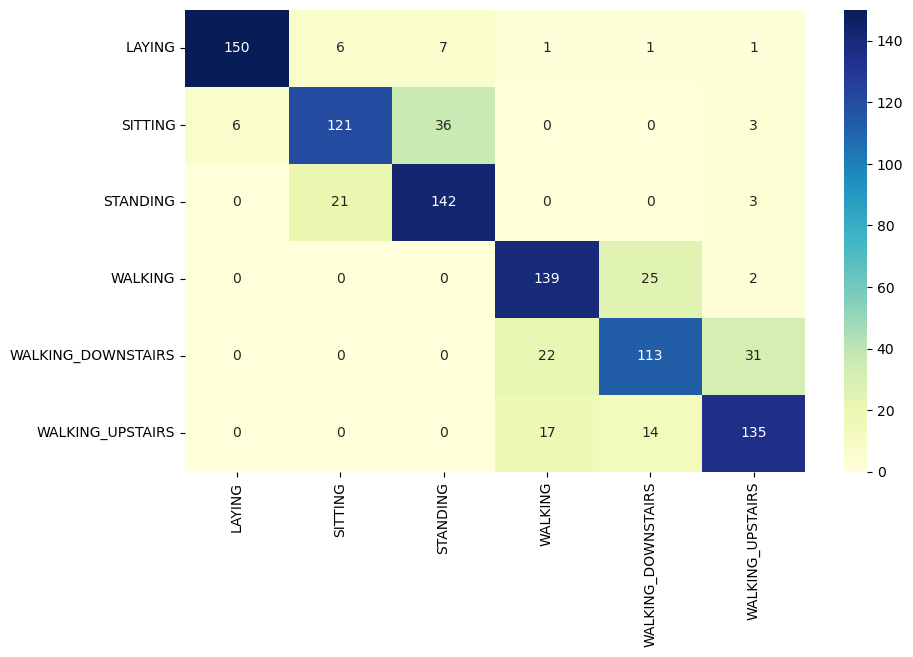

In [13]:
Y_prediction = model.predict(K_test)
#image
cm= confusion_matrix(Y_test,Y_prediction)
index = ['LAYING','SITTING','STANDING','WALKING','WALKING_DOWNSTAIRS','WALKING_UPSTAIRS'] 
columns = ['LAYING','SITTING','STANDING','WALKING','WALKING_DOWNSTAIRS','WALKING_UPSTAIRS'] 
cm_df = pd.DataFrame(cm,columns,index) 
plt.figure(figsize=(10,6))  
sns.heatmap(cm_df, annot=True,fmt="d",cmap="YlGnBu")